# 1-1(a) Plot the learning curves of J(w) and the accuracy of classification for every 50 iterations, with training data as well as test data, also, show the final loss and accuracy values. (20%)

In [1]:
# Example code for reading the data and the initial weights and biases.
# Note: This is just an example of how to read these files, you can modify the code in your own implementation.

import numpy as np
import matplotlib.pyplot as plt
Path = '/home/309707001/DL/HW/HW1/DL_HW1/'
train_x, train_y = np.load(Path + 'fashion_mnist/train_x.npy'), np.load(Path + 'fashion_mnist/train_y.npy')
test_x, test_y = np.load(Path + 'fashion_mnist/test_x.npy'), np.load(Path + 'fashion_mnist/test_y.npy')

print('shape of data:')
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)
print()

checkpoint = np.load(Path + 'weights.npy', allow_pickle=True).item()
init_weights = checkpoint['w']
init_biases = checkpoint['b']

print('shape of weights:')
for w in init_weights:
    print(w.shape)

print()

print('shape of biases:')
for b in init_biases:
    print(b.shape)

shape of data:
(30000, 784)
(30000,)
(5000, 784)
(5000,)

shape of weights:
(784, 2048)
(2048, 512)
(512, 5)

shape of biases:
(2048,)
(512,)
(5,)


In [2]:
Alist = sorted(list(set(train_y)))
y = np.zeros(shape = (train_y.shape[0], len(Alist)))
for idx in range(train_y.shape[0]):
    y[idx, train_y[idx]] = 1

In [3]:
def Softmax(X, w = init_weights):
    Up = np.exp(X)
    w[2]
    Down = np.tile(np.sum(Up, axis = 1).reshape(-1, 1), (1, w[2].shape[1]))
    return Up/Down

def Relu(x):
    return (x > 0)*x

def forward_pass(x = train_x/255, w = init_weights, b = init_biases):
    cache = dict()
    # Layer 1
    cache['z1'] = x@w[0] + np.tile(b[0].reshape((1, -1)), (x.shape[0], 1)) # (N, 784)(784, 2048) + (N, 2048)
    cache['a1'] = Relu(cache['z1']) # (N, 2048)
    # Layer 2
    cache['z2'] = cache['a1']@w[1] + np.tile(b[1].reshape((1, -1)), (cache['a1'].shape[0], 1)) # (N, 2048)(2048, 512) + (N, 512)
    cache['a2'] = Relu(cache['z2']) # (N, 512)
    # Layer 3
    cache['z3'] = cache['a2']@w[2] + np.tile(b[2].reshape((1, -1)), (cache['a2'].shape[0], 1)) # (N, 512)(512, 5) + (N, 5)
    cache['a3'] = Softmax(cache['z3'] - np.tile(np.max(cache['z3'], axis = 1).reshape(-1,1), (1, 5))) # (N, 5)
    prob = cache['a3']
    return (prob, cache)

In [4]:
def Cost(a3, Y, w):
    N = Y.shape[0]
    cost = 0
    for i in range(5):
        cost += np.sum(-np.log(a3 + 10**(-7))[:, i]*Y[:, i])
    cost /= N
    return cost

def backward(w, cache, x_train, y_train):
    # 單筆資料輸入
    m = x_train.shape[0]
    
    ### Layer 3
    dz3 = cache['a3'] - y_train # (N, 5)
    dw3 = (1/m)*cache['a2'].T@dz3 # (512, N)(N, 5)
    db3 = (1/m)*dz3.T@np.ones(shape = (dz3.shape[0], 1)).reshape(-1, ) # (5, )
    
    ### Layer 2
    da2 = dz3@w[2].T # (N, 5)(5, 512)
    dz2 = np.array(cache['a2'], copy = True) # (N, 512)
    dz2 = da2*np.heaviside(dz2, 0) # (N, 512)
    dw2 = (1/m)*cache['a1'].T@dz2 # (2048, N)(N, 512)
    db2 = (1/m)*dz2.T@np.ones(shape = (dz2.shape[0], 1)).reshape(-1, ) # (512, )

    ### Layer 1
    da1 = dz2@w[1].T # (N, 512)(512, 2048)
    dz1 = np.array(cache['a1'], copy = True) # (N, 2048)
    dz1 = da1*np.heaviside(dz1, 0) # (N, 2048)
    dw1 = (1/m)*x_train.T@dz1 # (784, N)(N, 2048)
    db1 = (1/m)*dz1.T@np.ones(shape = (dz1.shape[0], 1)).reshape(-1, ) #(2048, )

    grads = {'dw1': dw1, 'db1': db1, 'dw2': dw2, 'db2': db2, 'dw3': dw3, 'db3':db3}
    return grads

def update(w, b, grads, lr = 0.001):
    w[0] -= grads['dw1']*lr
    w[1] -= grads['dw2']*lr
    w[2] -= grads['dw3']*lr
    b[0] -= grads['db1']*lr
    b[1] -= grads['db2']*lr
    b[2] -= grads['db3']*lr
    return w, b

In [5]:
Alist = sorted(list(set(test_y)))
y_t = np.zeros(shape = (test_y.shape[0], len(Alist)))
for idx in range(test_y.shape[0]):
    y_t[idx, test_y[idx]] = 1

In [6]:
def FNN(x = train_x/255, y = y, w = init_weights, b = init_biases, epochs = 20,
        lr = 0.001, x_test = test_x/255, y_test = y_t, check_train = train_y, check_test = test_y):
    N = x.shape[0]
    COSTS1 = list()
    COSTS2 = list()
    ACCS1 = list()
    ACCS2 = list()
    for epoch in range(epochs):
        #IDX = np.random.choice([i for i in range(x.shape[0])], size = (x.shape[0]//200, 200), replace = False)
        IDX = [[i for i in range(j, j + 200)] for j in range(0, x.shape[0], 200)]
        print('\rEpoch Round:{0}'.format(epoch + 1), end = '')
        for iter in range(x.shape[0]//200):
            prob, cache = forward_pass(x[IDX[iter]], w, b)
            grads = backward(w, cache, x[IDX[iter]], y[IDX[iter]])
            w, b = update(w, b, grads, lr)
            if (iter + epoch + 2)%50 == 0:
                prob1, cache1 = forward_pass(x, w, b)
                prob2, cache2 = forward_pass(x_test, w, b)
                COSTS1.append(Cost(cache1['a3'], y, w))
                COSTS2.append(Cost(cache2['a3'], y_test, w))
                Result1 = np.argmax(cache1['a3'], axis = 1)
                Result2 = np.argmax(cache2['a3'], axis = 1)
                ACCS1.append(np.sum(Result1 == check_train)/N)
                ACCS2.append(np.sum(Result2 == check_test)/x_test.shape[0])            
                print('\rEpoch Round:{0}; Loss Value-Train:{1}, Test:{2}, Acc Value-Train:{3}, Test:{4}'.format(epoch + 1,
                                                                                                                COSTS1[-1],
                                                                                                                COSTS2[-1],
                                                                                                                ACCS1[-1],
                                                                                                                ACCS2[-1]), end = '')
    return w, b, COSTS1, COSTS2, ACCS1, ACCS2

def predict(x, w, b):
    probs, caches = forward_pass(x, w, b)
    return np.argmax(caches['a3'], axis = 1)

In [7]:
w, b, COSTS1, COSTS2, ACCS1, ACCS2 = FNN()

Epoch Round:20; Loss Value-Train:0.17235422379849397, Test:0.46097747730181743, Acc Value-Train:0.9891, Test:0.9714Test:0.97222

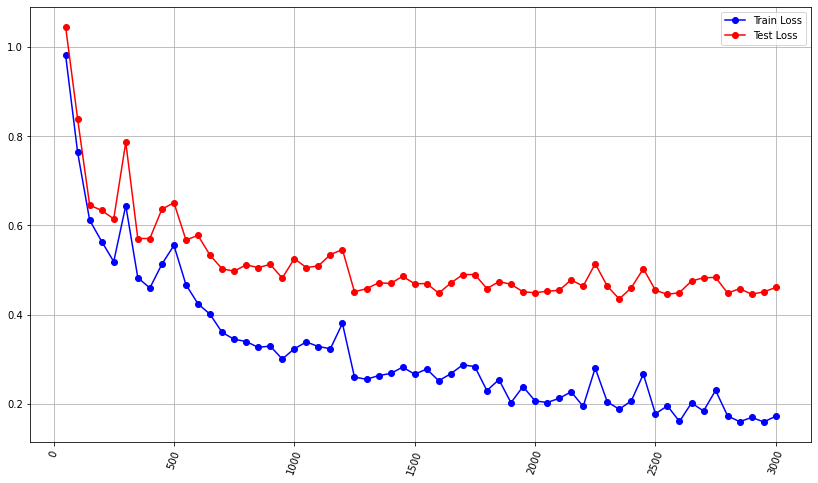

In [8]:
plt.figure(figsize = (14, 8))
plt.plot([(i + 1) * 50 for i in range(60)], COSTS1, '-o',label = 'Train Loss', color = 'blue')
plt.plot([(i + 1) * 50 for i in range(60)], COSTS2, '-o',label = 'Test Loss', color = 'red')
plt.xticks(rotation = 70)
plt.grid()
plt.legend()
plt.show()

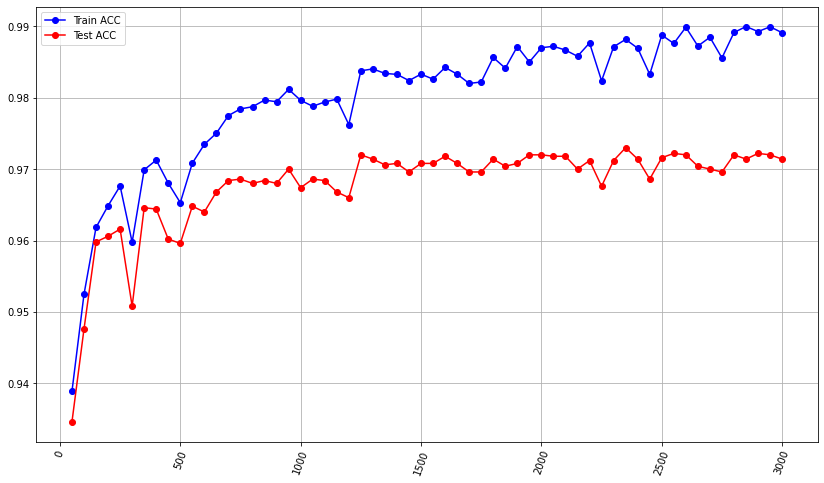

In [9]:
plt.figure(figsize = (14, 8))
plt.plot([(i + 1) * 50 for i in range(60)], ACCS1, '-o', label = 'Train ACC', color = 'blue')
plt.plot([(i + 1) * 50 for i in range(60)], ACCS2, '-o', label = 'Test ACC', color = 'red')
plt.xticks(rotation = 70)
plt.grid()
plt.legend()
plt.show()

In [10]:
print('最終結果－Train Loss:{0}, Train Acc:{1}, Test Loss:{2}, Test Acc:{3}'.format(COSTS1[-1], ACCS1[-1], COSTS2[-1], ACCS2[-1]))

最終結果－Train Loss:0.17235422379849397, Train Acc:0.9891, Test Loss:0.46097747730181743, Test Acc:0.9714


# 1-1(b) Repeat 1(a) by considering zero initialization for the model weights. And do some discussion. (8%)

In [68]:
zero_init = [np.zeros(shape = (784, 2048)), np.zeros(shape = (2048, 512)), np.zeros(shape = (512, 5))]
zero_b = [np.zeros(shape = (2048,)), np.zeros(shape = (512,)), np.zeros(shape = (5,))]

w, b, COSTS1, COSTS2, ACCS1, ACCS2 = FNN(w = zero_init)

Epoch Round:20; Loss Value-Train:1.6096925722986128, Test:1.6096924958483692, Acc Value-Train:0.2, Test:0.2

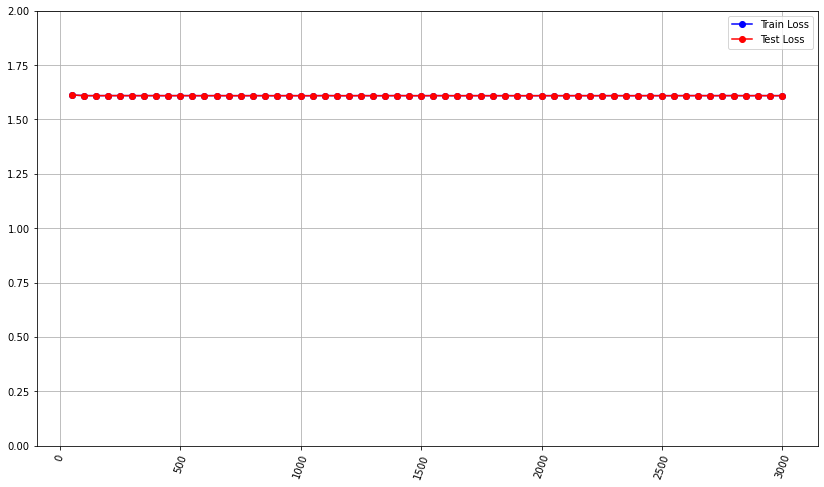

In [69]:
plt.figure(figsize = (14, 8))
plt.plot([(i + 1) * 50 for i in range(60)], COSTS1, '-o',label = 'Train Loss', color = 'blue')
plt.plot([(i + 1) * 50 for i in range(60)], COSTS2, '-o',label = 'Test Loss', color = 'red')
plt.ylim(0, 2)
plt.xticks(rotation = 70)
plt.grid()
plt.legend()
plt.show()

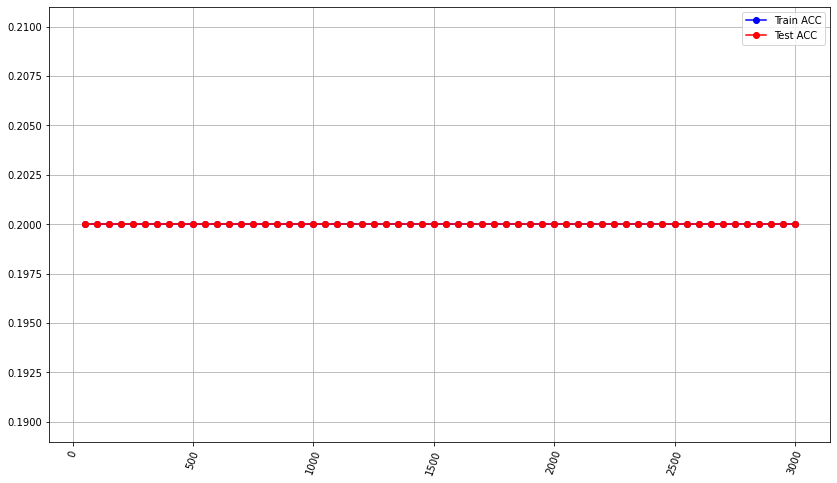

In [70]:
plt.figure(figsize = (14, 8))
plt.plot([(i + 1) * 50 for i in range(60)], ACCS1, '-o', label = 'Train ACC', color = 'blue')
plt.plot([(i + 1) * 50 for i in range(60)], ACCS2, '-o', label = 'Test ACC', color = 'red')
plt.xticks(rotation = 70)
plt.grid()
plt.legend()
plt.show()

In [71]:
print('最終結果－Train Loss:{0}, Train Acc:{1}, Test Loss:{2}, Test Acc:{3}'.format(COSTS1[-1], ACCS1[-1], COSTS2[-1], ACCS2[-1]))

最終結果－Train Loss:1.6096925722986128, Train Acc:0.2, Test Loss:1.6096924958483692, Test Acc:0.2


## 【Discussion】從上面的Learning curve可以看出，當初始化參數為0時，模型是沒辦法訓練的。原因是在做反向傳播時，假設第k層的輸入值對第k-1層的輸出值微分，會等於neuron的參數。初始化為零，則整個chain rule為零，梯度也變為零，進而使模型無法訓練。

# 1-2(a)Train the model using the same settings in 1 and repeat 1-1(a) (8%)

In [23]:
def forward_pass_with_dropout(x = train_x/255, w = init_weights, b = init_biases, rate = 0.2):
    IDX1 = np.where(np.random.binomial(size=784, n=1, p= 1 - rate) == 1)[0]
    IDX2 = np.where(np.random.binomial(size=2048, n=1, p= 1 - rate) == 1)[0]
    IDX3 = np.where(np.random.binomial(size=512, n=1, p= 1 - rate) == 1)[0]
    IDXS = [IDX1, IDX2, IDX3]
    cache = dict()
    # Layer 1
    cache['z1'] = x[:, IDX1]@w[0][IDX1, :] + np.tile(b[0].reshape((1, -1)), (x.shape[0], 1)) # (N, 784)(784, 2048) + (N, 2048)
    cache['a1'] = Relu(cache['z1']) # (N, 2048)
    # Layer 2
    cache['z2'] = cache['a1'][:, IDX2]@w[1][IDX2, :] + np.tile(b[1].reshape((1, -1)), (cache['a1'].shape[0], 1)) # (N, 2048)(2048, 512) + (N, 512)
    cache['a2'] = Relu(cache['z2']) # (N, 512)
    # Layer 3
    cache['z3'] = cache['a2'][:, IDX3]@w[2][IDX3, :] + np.tile(b[2].reshape((1, -1)), (cache['a2'].shape[0], 1)) # (N, 512)(512, 5) + (N, 5)
    cache['a3'] = Softmax(cache['z3'] - np.tile(np.max(cache['z3'], axis = 1).reshape(-1,1), (1, 5))) # (N, 5)
    prob = cache['a3']
    return (prob, cache, IDXS)

In [24]:
def backward_with_dropout(w, cache, x_train, y_train, IDXS):
    # 單筆資料輸入
    m = x_train.shape[0]
    # IDX1(784, )
    # IDX2(2048, )
    # IDX3(512, )
    # w1(784, 2048)
    # w2(2048, 512)
    # w3(512, 5)
    ### Layer 3
    IDX3 = IDXS[2]
    dz3 = cache['a3'] - y_train # (N, 5)
    dw3 = ((1/m)*cache['a2'].T@dz3)[IDX3] # (512, N)(N, 5)
    db3 = (1/m)*dz3.T@np.ones(shape = (dz3.shape[0], 1)).reshape(-1, ) # (5, )

    ### Layer 2
    IDX2 = IDXS[1]
    da2 = dz3@w[2].T # (N, 5)(5, 512)
    dz2 = np.array(cache['a2'], copy = True) # (N, 512)
    dz2 = da2*np.heaviside(dz2, 0) # (N, 512)
    dw2 = ((1/m)*cache['a1'].T@dz2)[IDX2] # (2048, N)(N, 512)
    db2 = (1/m)*dz2.T@np.ones(shape = (dz2.shape[0], 1)).reshape(-1, ) # (512, )

    ### Layer 1
    IDX1 = IDXS[0]
    da1 = dz2@w[1].T # (N, 512)(512, 2048)
    dz1 = np.array(cache['a1'], copy = True) # (N, 2048)
    dz1 = da1*np.heaviside(dz1, 0) # (N, 2048)
    dw1 = ((1/m)*x_train.T@dz1)[IDX1] # (784, N)(N, 2048)
    db1 = (1/m)*dz1.T@np.ones(shape = (dz1.shape[0], 1)).reshape(-1, ) #(2048, )

    grads = {'dw1': dw1, 'db1': db1, 'dw2': dw2, 'db2': db2, 'dw3': dw3, 'db3':db3}
    return (grads, IDXS)

In [25]:
def update_with_dropout(w, b, grads, IDXS, lr = 0.001):
    # IDX1(784, )
    # IDX2(2048, )
    # IDX3(512, )
    w[0][IDXS[0]] -= grads['dw1']*lr # (784, 2048)[IDX1]
    w[1][IDXS[1]] -= grads['dw2']*lr # (2048, 512)[IDX2]
    w[2][IDXS[2]] -= grads['dw3']*lr # (512, 5)[IDX3]
    b[0][IDXS[1]] -= grads['db1'][IDXS[1]]*lr # (2048, )[IDX2]
    b[1][IDXS[2]] -= grads['db2'][IDXS[2]]*lr # (512, )[IDX3]
    b[2] -= grads['db3']*lr # (5,)
    return w, b

In [26]:
def FNN_with_dropout(x = train_x/255, y = y, w = init_weights, b = init_biases, epochs = 20,
        lr = 0.001, x_test = test_x/255, y_test = y_t, check_train = train_y, check_test = test_y, rate = 0.2):
    N = x.shape[0]
    COSTS1 = list()
    COSTS2 = list()
    ACCS1 = list()
    ACCS2 = list()
    for epoch in range(epochs):
        # IDX = np.random.choice([i for i in range(x.shape[0])], size = (x.shape[0]//200, 200), replace = False)
        IDX = [[i for i in range(j, j + 200)] for j in range(0, x.shape[0], 200)]
        print('\rEpoch Round:{0}'.format(epoch + 1), end = '')
        for iter in range(x.shape[0]//200):
            prob, cache, IS = forward_pass_with_dropout(x[IDX[iter]], w, b, rate)
            grads, IS = backward_with_dropout(w, cache, x[IDX[iter]], y[IDX[iter]], IS)
            #grads = backward(w, cache, x[IDX[iter]], y[IDX[iter]])
            w, b = update_with_dropout(w, b, grads, IS, lr)
            if (iter + epoch + 2)%50 == 0:
                prob1, cache1= forward_pass(x, w, b)
                prob2, cache2= forward_pass(x_test, w, b)
                COSTS1.append(Cost(cache1['a3'], y, w))
                COSTS2.append(Cost(cache2['a3'], y_test, w))
                Result1 = np.argmax(cache1['a3'], axis = 1)
                Result2 = np.argmax(cache2['a3'], axis = 1)
                ACCS1.append(np.sum(Result1 == check_train)/N)
                ACCS2.append(np.sum(Result2 == check_test)/x_test.shape[0])            
                print('\rEpoch Round:{0}; Loss Value-Train:{1}, Test:{2}, Acc Value-Train:{3}, Test:{4}'.format(epoch + 1,
                                                                                                                COSTS1[-1],
                                                                                                                COSTS2[-1],
                                                                                                                ACCS1[-1],
                                                                                                                ACCS2[-1]), end = '')
    return w, b, COSTS1, COSTS2, ACCS1, ACCS2


In [27]:
w1, b1, COSTS1, COSTS2, ACCS1, ACCS2 = FNN_with_dropout(rate = 0.2)

Epoch Round:20; Loss Value-Train:0.4985493365466126, Test:0.6028342779608948, Acc Value-Train:0.969, Test:0.9626Test:0.949812

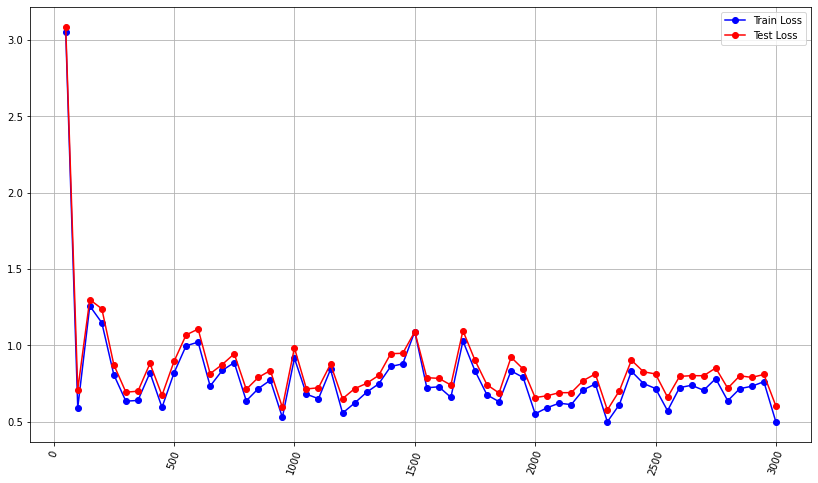

In [28]:
plt.figure(figsize = (14, 8))
plt.plot([(i + 1) * 50 for i in range(60)], COSTS1, '-o',label = 'Train Loss', color = 'blue')
plt.plot([(i + 1) * 50 for i in range(60)], COSTS2, '-o',label = 'Test Loss', color = 'red')
plt.xticks(rotation = 70)
plt.grid()
plt.legend()
plt.show()

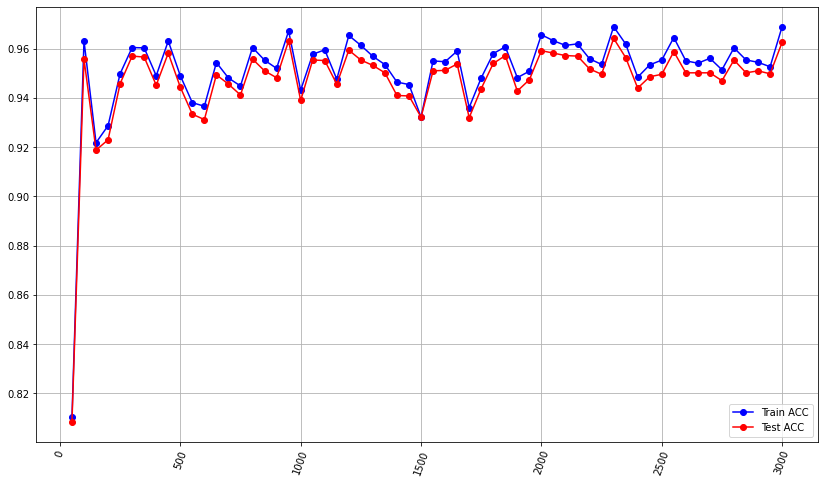

In [29]:
plt.figure(figsize = (14, 8))
plt.plot([(i + 1) * 50 for i in range(60)], ACCS1, '-o', label = 'Train ACC', color = 'blue')
plt.plot([(i + 1) * 50 for i in range(60)], ACCS2, '-o', label = 'Test ACC', color = 'red')
plt.xticks(rotation = 70)
plt.grid()
plt.legend()
plt.show()

In [30]:
print('最終結果－Train Loss:{0}, Train Acc:{1}, Test Loss:{2}, Test Acc:{3}'.format(COSTS1[-1], ACCS1[-1], COSTS2[-1], ACCS2[-1]))

最終結果－Train Loss:0.4985493365466126, Train Acc:0.969, Test Loss:0.6028342779608948, Test Acc:0.9626


# 1-2(b) Based on the experimental results, how the dropout layers affect the model performance and why? Please do some discussion.

## 【Discussion】在使用dropout後，我們可以發現到不論在accuracy或是loss的圖，training curve和testing curve的差距會大幅縮短。這表示overfitting的狀況在dropout後，得到了改善。

## Dropout的功能為隨機將部分的neuron遮住，不放入模型中進行foward pass和backward propogation，因此各層的訓練參數會類似於平均值的概念，進而有上述防止overfitting的結果。

# 1-3(a) Show the classification accuracy of these noise images with respect to the random labels before and after the updates.

In [11]:
x_tr = np.random.normal(0, 1, size = (256 ,train_x.shape[1]))
y_tr = np.random.randint(0, 5, size = (x_tr.shape[0], ))
x_ts = np.random.normal(0, 1, size = (256 ,test_x.shape[1]))
y_ts = np.random.randint(0, 5, size = (x_ts.shape[0], ))

In [12]:
Alist = sorted(list(set(y_tr)))
y_one_tr = np.zeros(shape = (y_tr.shape[0], len(Alist)))
for idx in range(y_tr.shape[0]):
    y_one_tr[idx, y_tr[idx]] = 1

In [13]:
Alist = sorted(list(set(y_ts)))
y_one_ts = np.zeros(shape = (y_ts.shape[0], len(Alist)))
for idx in range(y_ts.shape[0]):
    y_one_ts[idx, y_ts[idx]] = 1

In [14]:
def Cost(a3, Y, w):
    N = Y.shape[0]
    cost = 0
    for i in range(5):
        cost += np.sum(-np.log(a3 + 10**(-7))[:, i]*Y[:, i])
    cost /= N
    return cost

def backward_another(w, cache, x_train, y_train):
    # 單筆資料輸入
    m = x_train.shape[0]
    ### Layer 3
    dz3 = cache['a3'] - y_train # (N, 5)
    
    ### Layer 2
    da2 = dz3@w[2].T # (N, 5)(5, 512)
    dz2 = np.array(cache['a2'], copy = True) # (N, 512)
    dz2 = da2*np.heaviside(dz2, 0) # (N, 512)
    
    ### Layer 1
    da1 = dz2@w[1].T # (N, 512)(512, 2048)
    dz1 = np.array(cache['a1'], copy = True) # (N, 2048)
    dz1 = da1*np.heaviside(dz1, 0) # (N, 2048)
    
    # Input Data
    dx = (1/m)*dz1@w[0].T # (N, 2048)(2048, 784)
    
    grads = {'dx': dx}
    return grads

def update_another(x, grads, lr = 0.001):
    x -= grads['dx']*lr
    return x

In [15]:
def FNN_another(x = x_tr, y = y_one_tr, w = init_weights, b = init_biases, epochs = 20,
        lr = 0.001, x_test = x_ts/255, y_test = y_one_ts, check_train = y_tr, check_test = y_ts):
    N = x.shape[0]
    COSTS1 = list()
    COSTS2 = list()
    ACCS1 = list()
    ACCS2 = list()
    for epoch in range(epochs):
        #IDX = np.random.choice([i for i in range(x.shape[0])], size = (x.shape[0]//200, 200), replace = False)
        print('\rEpoch Round:{0}'.format(epoch + 1), end = '')
        prob, cache = forward_pass(x, w, b)
        grads = backward_another(w, cache, x, y)
        x = update_another(x, grads, lr)
        #if (iter + epoch + 2)%50 == 0:
        prob1, cache1 = forward_pass(x, w, b)
        prob2, cache2 = forward_pass(x_test, w, b)
        COSTS1.append(Cost(cache1['a3'], y, w))
        COSTS2.append(Cost(cache2['a3'], y_test, w))
        Result1 = np.argmax(cache1['a3'], axis = 1)
        Result2 = np.argmax(cache2['a3'], axis = 1)
        ACCS1.append(np.sum(Result1 == check_train)/N)
        ACCS2.append(np.sum(Result2 == check_test)/x_test.shape[0])            
        print('\rEpoch Round:{0}; Loss Value-Train:{1}, Test:{2}, Acc Value-Train:{3}, Test:{4}'.format(epoch + 1,
                                                                                                        COSTS1[-1],
                                                                                                        COSTS2[-1],
                                                                                                        ACCS1[-1],
                                                                                                        ACCS2[-1]), end = '')
    return COSTS1, COSTS2, ACCS1, ACCS2

In [31]:
x_tr

array([[-0.05504065, -0.42498272, -0.01663114, ..., -0.78746049,
        -0.33808574,  0.83479624],
       [-0.38370838, -1.36744604, -0.24520169, ...,  0.67304379,
         1.3794149 ,  0.5130307 ],
       [-0.53212102,  1.49654221, -1.06335514, ..., -0.33877467,
        -1.73052945, -1.99706778],
       ...,
       [-0.05034887, -0.33919121, -0.45477706, ...,  0.44979233,
         0.18772511, -0.020488  ],
       [-0.31106084, -1.66507874,  1.57806621, ...,  0.75317767,
         1.66576407,  0.42464172],
       [ 0.06287333,  1.02614024,  0.05066878, ...,  0.33826624,
         2.40429386,  1.40369735]])

In [16]:
COSTS1, COSTS2, ACCS1, ACCS2 = FNN_another()

Epoch Round:20; Loss Value-Train:4.470253019307678, Test:12.781146140017732, Acc Value-Train:0.72265625, Test:0.20703125

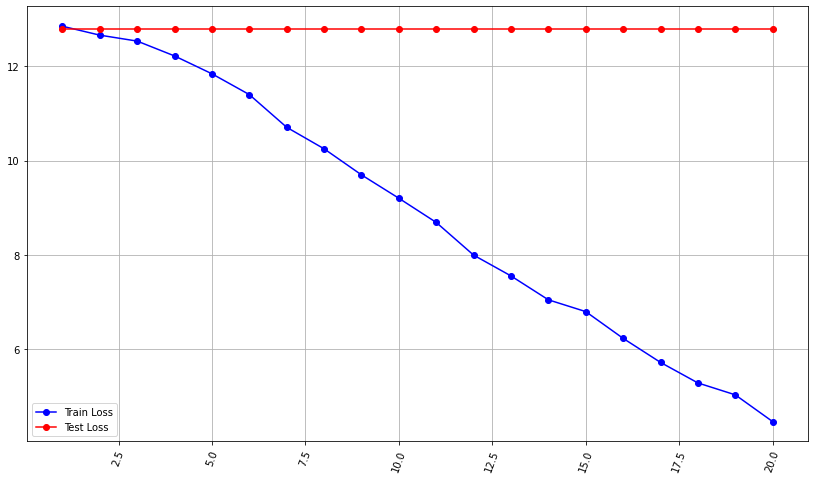

In [17]:
plt.figure(figsize = (14, 8))
plt.plot([(i + 1) for i in range(20)], COSTS1, '-o',label = 'Train Loss', color = 'blue')
plt.plot([(i + 1) for i in range(20)], COSTS2, '-o',label = 'Test Loss', color = 'red')
plt.xticks(rotation = 70)
plt.grid()
plt.legend()
plt.show()

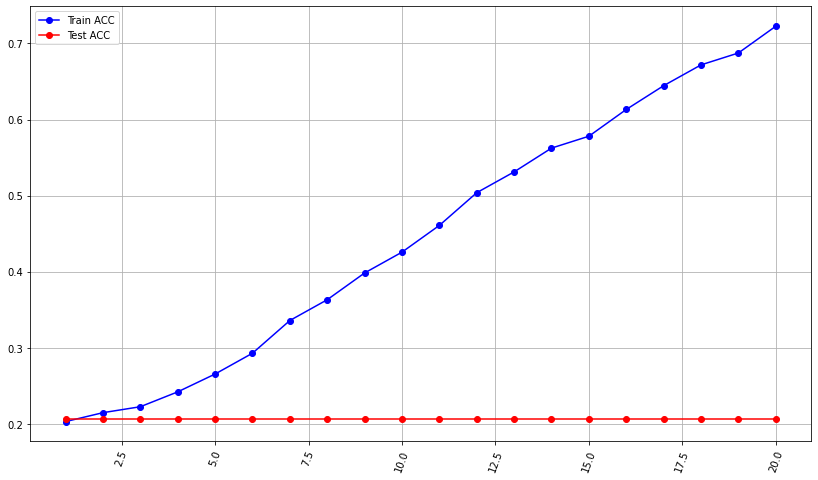

In [18]:
plt.figure(figsize = (14, 8))
plt.plot([(i + 1) for i in range(20)], ACCS1, '-o', label = 'Train ACC', color = 'blue')
plt.plot([(i + 1) for i in range(20)], ACCS2, '-o', label = 'Test ACC', color = 'red')
plt.xticks(rotation = 70)
plt.grid()
plt.legend()
plt.show()

# 1-3(b) Based on the result, explain your findings. What do these updated inputs tell us about the trained model? 

## 【Discussion】這邊我生成了兩組random label data，一組(training)有放入模型更新，另一組(testing)作為對照組。從實驗結果可以比較出，training data在訓練後performance可以提升accuracy，而testing data則符合預期，因為沒有經過訓練，因此perfomance保持不變。

## 我們檢查此實驗輸入與輸出的圖像結果如下：(上圖為輸入、下圖為輸出)

# 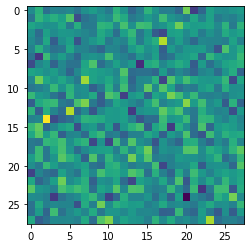 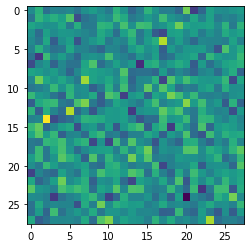

## 因此我們可以得知，數據上微小的差異對於圖像辨識會有顯著的影響。換句話說，如果圖片中被放入噪音Noise，則模型對於圖形辨識的結果也可能大不相同，這會是神經網路做影像辨識的一大問題。